In [6]:
import cv2
import pytesseract
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Set Tesseract path if not in system PATH
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [7]:
image_path = "sudoku/1.png"
actual_grid = [
    [1, 8, 7, 5, 4, 9, 3, 8, 2],
    [6, 2, 3, 7, 6, 1, 4, 5, 9],
    [4, 9, 5, 2, 8, 3, 1, 6, 7],
    [7, 4, 1, 6, 3, 8, 9, 2, 5],
    [5, 3, 8, 9, 1, 2, 6, 7, 4],
    [2, 6, 9, 4, 7, 5, 8, 3, 1],
    [8, 5, 4, 1, 2, 6, 7, 9, 3],
    [9, 7, 6, 3, 5, 4, 2, 1, 8],
    [3, 1, 2, 8, 9, 7, 5, 4, 6],
]

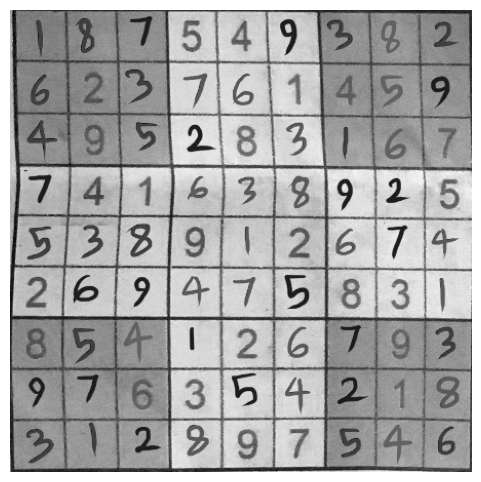

In [8]:
# Load the Sudoku image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply preprocessing (Thresholding)
_, thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

# Find contours to detect grid
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and select the largest (assuming it's the grid)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Set default width and height (in case grid detection fails)
width, height = 450, 450  

# Get bounding box of the grid
sudoku_grid = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
    if len(approx) == 4:  # Looking for a quadrilateral (Sudoku Grid)
        sudoku_grid = approx
        break

# Warp perspective if necessary (To get a straight grid)
if sudoku_grid is not None:
    pts = np.array([sudoku_grid[i][0] for i in range(4)], dtype="float32")

    # Sort the points in the correct order
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)  # Sum of x and y coordinates
        diff = np.diff(pts, axis=1)  # Difference (y - x)

        rect[0] = pts[np.argmin(s)]  # Top-left
        rect[2] = pts[np.argmax(s)]  # Bottom-right
        rect[1] = pts[np.argmin(diff)]  # Top-right
        rect[3] = pts[np.argmax(diff)]  # Bottom-left

        return rect

    ordered_pts = order_points(pts)  # Ensure correct order
    pts_dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

    # Compute transformation matrix
    M = cv2.getPerspectiveTransform(ordered_pts, pts_dst)
    image = cv2.warpPerspective(image, M, (width, height))
else:
    image = cv2.resize(image, (width, height))  # Resize image instead if grid detection fails

plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.show()

In [9]:
# result = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# kernel = np.ones((2,2), np.uint8)
# result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)

# result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
# kernel = np.ones((3, 3), np.uint8)

# grid_mask = None

# for width in range(1, 3, 1):
#     for length in range(8, 50, 10):
#         h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (length, width))
#         horizontal = cv2.morphologyEx(result, cv2.MORPH_OPEN, h_kernel, iterations=5)
#         v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width, length))
#         vertical = cv2.morphologyEx(result, cv2.MORPH_OPEN, v_kernel, iterations=5)
#         if grid_mask is None:
#             grid_mask = cv2.bitwise_or(horizontal, vertical)
#         else:
#             grid_mask = cv2.bitwise_or(grid_mask, cv2.bitwise_or(horizontal, vertical))

# for width in range(1, 5, 1):
#     for length in range(1, 5, 1):
#         kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (length, width))
#         removed_dots = cv2.morphologyEx(result, cv2.MORPH_OPEN, v_kernel, iterations=5)
#         grid_mask = cv2.bitwise_or(grid_mask, removed_dots)

# grid_mask_inv = cv2.bitwise_not(grid_mask)
# result = cv2.bitwise_and(result, grid_mask_inv)
# result = cv2.bitwise_not(result)

# plt.figure(figsize=(6,6))
# plt.imshow(result, cmap='gray')
# plt.axis("off")
# plt.show()

In [19]:
width, height = image.shape

cell_size = width // 9
sudoku_numbers = []
undetected_cnt = 0
incorrect_cnt = 0

cells = []

def isdigit(number):
    return number.isdigit() and len(number) == 1

for row in range(9):
    row_numbers = []
    for col in range(9):
        x, y = col * cell_size, row * cell_size
        cell = image[y:y + cell_size, x:x + cell_size]
        
        cwidth, cheight = cell.shape
        cell = cell[int(cwidth*0.1):int(cwidth*0.95), int(cheight*0.2):int(cheight*0.9)]
        
        cell = cv2.GaussianBlur(cell, (3,3), 0)
        _, cell = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        kernel = np.ones((2, 2), np.uint8)
        cell = cv2.morphologyEx(cell, cv2.MORPH_OPEN, kernel)

        custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=123456789'
        number = pytesseract.image_to_string(cell, config=custom_config, lang="eng").strip()

        if not isdigit(number):
            cell = cv2.morphologyEx(cell, cv2.MORPH_CLOSE, kernel)
            number = pytesseract.image_to_string(cell, config=custom_config, lang="eng").strip()

        if not isdigit(number):
            cell = cv2.bitwise_not(cell)
            cell = cv2.dilate(cell, kernel, iterations=1)
            cell = cv2.bitwise_not(cell)
            number = pytesseract.image_to_string(cell, config=custom_config, lang="eng").strip()

        incorrect = isdigit(number) and str(actual_grid[row][col]) != number
        cells += [{'img': cell, 'undetected': not isdigit(number), 'number': number, 'incorrect': incorrect}]

        if not isdigit(number):
            undetected_cnt += 1
        if incorrect:
            incorrect_cnt += 1

        # Store the recognized number
        row_numbers.append(number if isdigit(number) else "_")
    
    sudoku_numbers.append(row_numbers)

print(f"undetected = {undetected_cnt}")
print(f"incorrect = {incorrect_cnt}")


undetected = 11
incorrect = 6


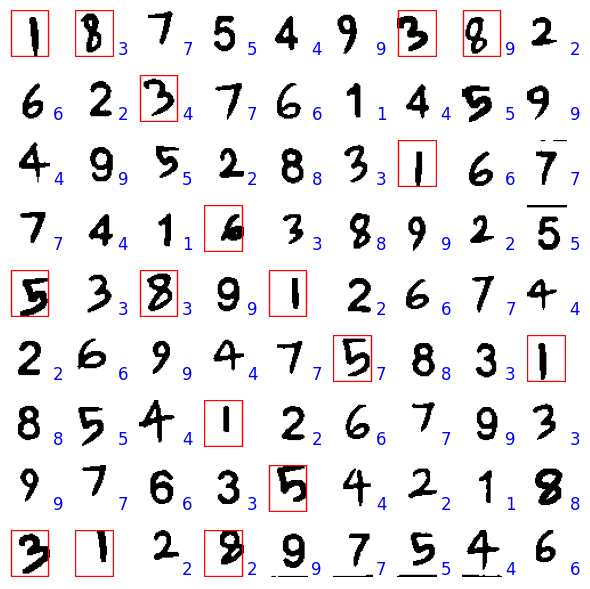

In [20]:
fig, axes = plt.subplots(9, 9, figsize=(6, 6)) 
for ax, img in zip(axes.ravel(), cells):
    ax.imshow(img['img'], cmap='gray')
    ax.axis('off')
    height, width = img['img'].shape
    if img['undetected'] or img['incorrect']:
        rect = patches.Rectangle(
            (0, 0), width-2, height-2, linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
    if not img['undetected']:
        ax.text(
            height, width,
            img['number'],
            color='blue', fontsize=12, fontweight='normal',
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0, edgecolor='none')
        )

plt.tight_layout()
plt.show()

In [12]:
def is_valid_sudoku(grid):
    def is_unique(lst):
        """Check if a list contains unique numbers (ignoring '_')."""
        nums = [num for num in lst if num != "_"]
        return len(nums) == len(set(nums))  # Ensure no duplicates

    # Check rows
    for row in grid:
        if not is_unique(row):
            return False

    # Check columns
    for col in range(9):
        if not is_unique([grid[row][col] for row in range(9)]):
            return False

    # Check 3x3 subgrids
    for box_row in range(0, 9, 3):
        for box_col in range(0, 9, 3):
            subgrid = [
                grid[r][c]
                for r in range(box_row, box_row + 3)
                for c in range(box_col, box_col + 3)
            ]
            if not is_unique(subgrid):
                return False

    return True

for row in sudoku_numbers:
    print(" ".join(row))
    
# Verify Sudoku
print("\nValid Sudoku?" , is_valid_sudoku(sudoku_numbers))

_ 3 7 5 4 9 _ 9 2
6 2 4 7 6 1 4 5 9
4 9 5 2 8 3 _ 6 7
7 4 1 _ 3 8 9 2 5
_ 3 3 9 _ 2 6 7 4
2 6 9 4 7 7 8 3 _
8 5 4 _ 2 6 7 9 3
9 7 6 3 _ 4 2 1 8
_ _ 2 2 9 7 5 4 6

Valid Sudoku? False
